#**Analysis of Language in Amazon Reviews**
#####Contributors: *Joe, Jana, and Grace*
#####Sources: *https://amazon-reviews-2023.github.io/*

# **Overview:**
This project focuses on sentiment analysis with the aim of exploring how language in product reviews correlates with positive or negative emotions and how this relationship evolves over time. The goal is to use reviews to assess what language is associated with positive/negative emotions and how that vocabulary has changed over time. It speaks to general language patterns across generations: for example, the level of negativity/positivity associated with certain ratings. Moreover, it is interesting to observe how language usage varies across categories of retail, as well as general sentiment towards those products. This project was particularly interesting to us since we wanted to build off of the technique of using time as a feature. Additionally, we both have an interest in sentiment analysis and language processing, and we would like to tie that in with hypothesis testing techniques learned in this course. Ultimately, we would like to be able to make generalizations about the patterns in review crafting as influenced by industry, time, and a multitude of other factors.

In this project, we will be focusing on reviews of products categorized as **CDs and Vinyl**.


In [ ]:
RANDOM_SEED = 42

##**Preprocessing:**

This script pre-processes Amazon review data for a selected category. It downloads and converts the review and metadata datasets into Pandas DataFrames, merges them based on a common identifier, and filters out invalid or incomplete entries. The code ensures that price values are numeric and removes problematic rows. A subset of 100,000 samples is randomly selected, and specific columns are cast to appropriate data types to prepare the data for analysis.

###***Installs/Imports:***

In [ ]:
#Installs:
!pip install datasets
!pip install pandas scikit-learn nltk
!pip install wordcloud
!pip install statsmodels
!pip install imblearn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Imports:
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import load_dataset_builder
from matplotlib import pyplot as plt
import seaborn as sns
import random
import re

###***Load Amazon Review Dataset:***

In [ ]:
# List of possible sampling categories
selected_categories = [
    "All_Beauty",
    "Amazon_Fashion",
    "Appliances",
    "Arts_Crafts_and_Sewing",
    "Automotive",
    "Baby_Products",
    "Beauty_and_Personal_Care",
    "Books",
    "CDs_and_Vinyl",
    "Cell_Phones_and_Accessories",
    "Clothing_Shoes_and_Jewelry",
    "Digital_Music",
    "Electronics",
    "Gift_Cards",
    "Grocery_and_Gourmet_Food",
    "Handmade_Products",
    "Health_and_Household",
    "Health_and_Personal_Care",
    "Home_and_Kitchen",
    "Industrial_and_Scientific",
    "Kindle_Store",
    "Magazine_Subscriptions",
    "Movies_and_TV",
    "Musical_Instruments",
    "Office_Products",
    "Patio_Lawn_and_Garden",
    "Pet_Supplies",
    "Software",
    "Sports_and_Outdoors",
    "Subscription_Boxes",
    "Tools_and_Home_Improvement",
    "Toys_and_Games",
    "Video_Games",
    "Unknown"
]

In [ ]:
#@title Download the Dataset (We will be Using the CD and Vinyl Category):
selected_category = "CDs_and_Vinyl"

review_df = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_" + selected_category, trust_remote_code=True)
item_df = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_" + selected_category, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

CDs_and_Vinyl.jsonl:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

meta_CDs_and_Vinyl.jsonl:   0%|          | 0.00/949M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
#@title Convert Our Dataset to a Pandas DF:
review_df = review_df["full"]
review_df = review_df.to_pandas()

In [ ]:
#@title Convert Our Secondary Items Dataset to a Pandas DF:
item_df = item_df["full"]
item_df = item_df.to_pandas()
item_df = item_df[['main_category', 'title', 'average_rating', 'rating_number', 'price', 'store', 'parent_asin']]

In [ ]:
#@title Merge the Review and Item Dataframes
review_df = pd.merge(review_df, item_df, left_on = 'parent_asin', right_on = 'parent_asin', how = 'left', suffixes = ('', '_item'))

In [ ]:
#@title Display Sample Output:
review_df_num_rows = len(review_df)
print("----------------------------------------------------")
print("Our dataframe has", review_df_num_rows, "reviews")
print("----------------------------------------------------")
print("\nEach review has the following attributes:")
print(review_df.columns)
print("----------------------------------------------------")
print("\nAn example of one such review is:")
review_df.head(1)

----------------------------------------------------
Our dataframe has 4827273 reviews
----------------------------------------------------

Each review has the following attributes:
Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'main_category',
       'title_item', 'average_rating', 'rating_number', 'price', 'store'],
      dtype='object')
----------------------------------------------------

An example of one such review is:


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title_item,average_rating,rating_number,price,store
0,5.0,Five Stars,LOVE IT!,[],B002MW50JA,B002MW50JA,AGKASBHYZPGTEPO6LWZPVJWB2BVA,1452650777000,0,True,Digital Music,Filter US Recordings Music Teaching Material M...,4.6,186,19.61,Yo Gabba Gabba! Format: Audio CD


##***Drop Nulls (Preprocessing)***

In [ ]:
review_df.dropna(inplace = True)
review_df.reset_index(drop = True, inplace = True)

##***Drop All Reviews of Items with invalid Price (Preprocessing)***

In [ ]:
#Isn't "None"
review_df = review_df[review_df['price'] != "None"]
#doesnt contain "From"
review_df = review_df[~review_df['price'].str.contains("from")]
#doesnt contain "-"
review_df = review_df[~review_df['price'].str.contains("—")]
review_df.reset_index(drop = True, inplace = True)

#Here, check to make sure that all of our prices are valid floats
error_rows = review_df[review_df['price'].apply(lambda x: not isinstance(x, float) and not isinstance(x, int) and not (isinstance(x, str) and x.replace('.', '', 1).isdigit()))]
assert len(error_rows) == 0

##***Sample 100k Reviews for Time Optimization (Preprocessing)***

In [ ]:
review_df = review_df.sample(n = 100000, random_state = RANDOM_SEED)
review_df.reset_index(drop = True, inplace = True)

##***Column Type Casting (Preprocessing)***

***Note that our dtypes are innacurate:***

In [ ]:
#Show our dtypes
review_df.dtypes

,0
rating,float64
title,object
text,object
images,object
asin,object
parent_asin,object
user_id,object
timestamp,int64
helpful_vote,int64
verified_purchase,bool


***Here we cast the column types to fix that issue:***

In [ ]:
#Columns to cast & their corresponding new types:
considered_cast_cols = [
    ("title","string"),
    ("text","string"),
    ("asin","string"),
    ("parent_asin","string"),
    ("user_id","string"),
    ("verified_purchase", "int64"),
    ("main_category", "string"),
    ("title_item", "string"),
    ("price", "float64"),
    ("store", "string")
]

In [ ]:
#Cast our column types:
for temp_col in considered_cast_cols:
  print("|", "Column: ",temp_col[0], "| ", "Before:", review_df[temp_col[0]].dtypes, end = "  |  ")
  review_df[temp_col[0]] = review_df[temp_col[0]].astype(temp_col[1])
  print("After:", review_df[temp_col[0]].dtypes, "|")

| Column:  title |  Before: object  |  After: string |
| Column:  text |  Before: object  |  After: string |
| Column:  asin |  Before: object  |  After: string |
| Column:  parent_asin |  Before: object  |  After: string |
| Column:  user_id |  Before: object  |  After: string |
| Column:  verified_purchase |  Before: bool  |  After: int64 |
| Column:  main_category |  Before: object  |  After: string |
| Column:  title_item |  Before: object  |  After: string |
| Column:  price |  Before: object  |  After: float64 |
| Column:  store |  Before: object  |  After: string |


In [ ]:
#@title Add our Review Time column (to convert from a unix timestamp)
review_df['review_time'] = pd.to_datetime(review_df['timestamp'], unit='ms')
review_df['review_time'].head(3)

,review_time
0,2012-10-11 15:40:54.000
1,2020-06-07 11:58:08.132
2,2013-01-22 06:26:05.000


###Add a review length and review year column
This will be important later for *Hypothesis Testing* and *Predictive Modeling*

In [ ]:
review_df['review_length'] = review_df['text'].apply(lambda x: len(x.split()))
review_df['review_year'] = pd.to_datetime(review_df['review_time']).dt.year
review_df['review_year'].head(3)

,review_year
0,2012
1,2020
2,2013


In [ ]:
#@title Accounting for Outliers: Remove Review Years with a Small number of Samples
sample_sizes = review_df.groupby('review_year').size()

#We are setting the threshold to be at 500 samples
min_sample_size = 500
valid_years = sample_sizes[sample_sizes >= min_sample_size].index
nlp_review_df = review_df[review_df['review_year'].isin(valid_years)]

#Display the sample sizes (and if their corresponding year ended up being included)
print("Sample Sizes:")
print(sample_sizes)
print("\nFiltered Sample Sizes:")
sample_sizes = nlp_review_df.groupby('review_year').size()
print(sample_sizes)

Sample Sizes:
review_year
1998      147
1999      596
2000     2161
2001     1957
2002     2092
2003     2436
2004     2877
2005     3674
2006     2903
2007     3163
2008     2720
2009     2656
2010     2486
2011     2453
2012     3438
2013     7043
2014     9327
2015    10790
2016     8679
2017     6738
2018     5283
2019     5105
2020     3523
2021     3910
2022     2828
2023     1015
dtype: int64

Filtered Sample Sizes:
review_year
1999      596
2000     2161
2001     1957
2002     2092
2003     2436
2004     2877
2005     3674
2006     2903
2007     3163
2008     2720
2009     2656
2010     2486
2011     2453
2012     3438
2013     7043
2014     9327
2015    10790
2016     8679
2017     6738
2018     5283
2019     5105
2020     3523
2021     3910
2022     2828
2023     1015
dtype: int64


In [ ]:
#@title Add our Images Included column (int value)
review_df['images_included'] = review_df['images'].apply(lambda x: len(x) > 0).astype(int)
review_df['images_included'].head(3)

,images_included
0,0
1,0
2,0


In [ ]:
#@title Verify that our dtypes are correct (the only *Object* type should be for "images")
review_df.dtypes

,0
rating,float64
title,string[python]
text,string[python]
images,object
asin,string[python]
parent_asin,string[python]
user_id,string[python]
timestamp,int64
helpful_vote,int64
verified_purchase,int64


##***Create a Dataframe of all Numerical Features (Preprocessing)***

In [ ]:
#@title Dataframe of Relevant Numerical Features (excluding unix timestamp: no meaningful information in an "unengineered" state):
num_review_df = review_df[['rating','helpful_vote','verified_purchase','images_included','average_rating','rating_number','price', 'review_length']]
num_review_df.head(3)

,rating,helpful_vote,verified_purchase,images_included,average_rating,rating_number,price,review_length
0,5.0,0,1,0,4.8,3861,15.99,31
1,4.0,0,1,0,4.6,303,9.42,2
2,4.0,0,0,0,4.8,3609,11.98,62


In [ ]:
#@title Perform a simple test to verify no loss of data
assert len(review_df) == len(num_review_df)

##***Seperate Image and Non-Image Reviews (Preprocessing)***

In [ ]:
# @title Dataframe of Reviews WITHOUT Images Included:
review_df_no_images = review_df[review_df['images'].apply(len) == 0]
review_df_no_images.reset_index(drop = True, inplace = True)

In [ ]:
# @title Dataframe of Reviews WITH Images Included:
review_df_yes_images = review_df[review_df['images'].apply(len) != 0]
review_df_yes_images.reset_index(drop = True, inplace = True)

In [ ]:
# @title Testing our Partition (Image vs. Non-Image Reviews):
#Size preserving
assert len(review_df) == len(review_df_no_images) + len(review_df_yes_images)
#Check if all values in the 'images' column of df_no_images are empty lists.
assert (review_df_no_images['images'].apply(len) == 0).all()
#Check if at least one list in the images column of df_yes_images is not empty
assert (review_df_yes_images['images'].apply(lambda x: len(x) > 0)).any()

##**Visualizations:**

This visualization script provides an in-depth analysis of the numeric features and relationships in the review dataset. It includes:

- Correlation Heatmap: Displays the correlation between numeric features, highlighting relationships between variables. This provided meaningful insight into how to construct our predictive models (i.e. which features to include for each unique target output).

- Distribution and Count Plots: Explores the distribution of ratings, the frequency of verified purchases, and whether reviews include images. This illustrated the relatively high frequency of 5-star reviews and suggested that we would have to add steps to our modeling pipeline to address class imbalance (like upsampling). Additionally, we saw that not many reviews included images, discouraging us from honing in too much on the impact of image inclusion.

- Scatter Plots: Visualizes the relationship between ratings and helpful votes, with colors indicating image inclusion and purchase verification. While the colors (according to verified purchase and image inclusion) weren't particularly helpful, we found the "U" shape of the rating vs. helpful votes chart interesting as it suggested that polarizing reviews (1 & 5 stars) were generally seen as most helpful.

- Violin Plot: Examines the distribution of helpful votes across ratings, excluding extreme outliers (top 5%), for a clearer view of the data trends. This helped visualize where most reviews of a specific rating number were falling (i.e. the density) on the axis of helpful reviews.

These visualizations provide insights into review patterns and the impact of certain features like verified purchases and image inclusion. After generating these visualizations, we feel much more well equipped to begin working with our features in modeling.

##***Numerical Feature Correlation Heatmap:***

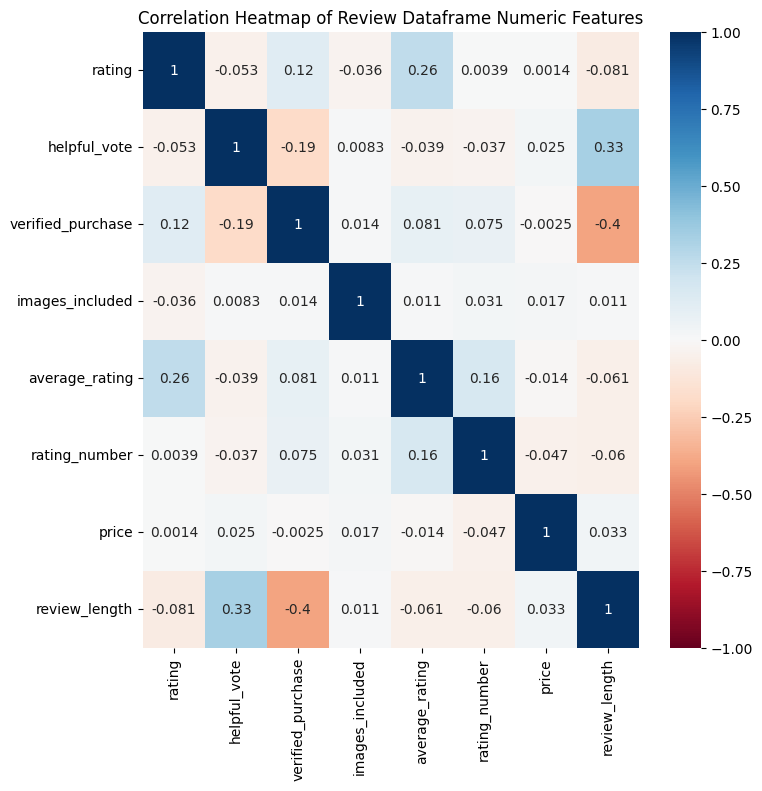

In [ ]:
# TODO: Plot correlation heatmap (2 Manually Graded Points + 2 autograded points)
corr_mat = num_review_df.corr()
fig = plt.figure(figsize = (8, 8))
plt.title("Correlation Heatmap of Review Dataframe Numeric Features")
sns.heatmap(corr_mat, cmap = 'RdBu', vmin = -1, vmax = 1, annot = True)
plt.show()

##***Numerical Feature Distribution Plots:***

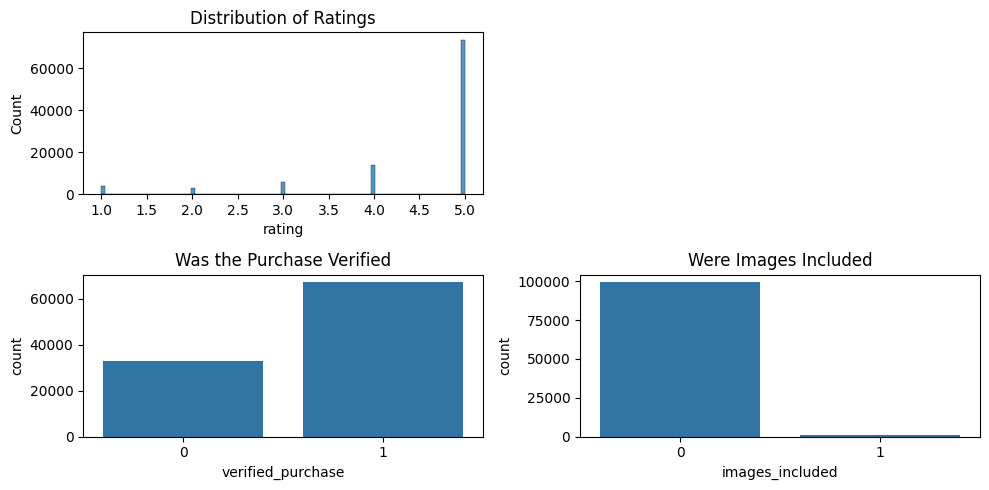

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
sns.histplot(num_review_df['rating'])
plt.title('Distribution of Ratings')

plt.subplot(2, 2, 3)
sns.countplot(x='verified_purchase', data=num_review_df)
plt.title('Was the Purchase Verified')

plt.subplot(2, 2, 4)
sns.countplot(x='images_included', data=num_review_df)
plt.title('Were Images Included')

plt.tight_layout()
plt.show()

##***Numerical Feature Scatter Plots:***

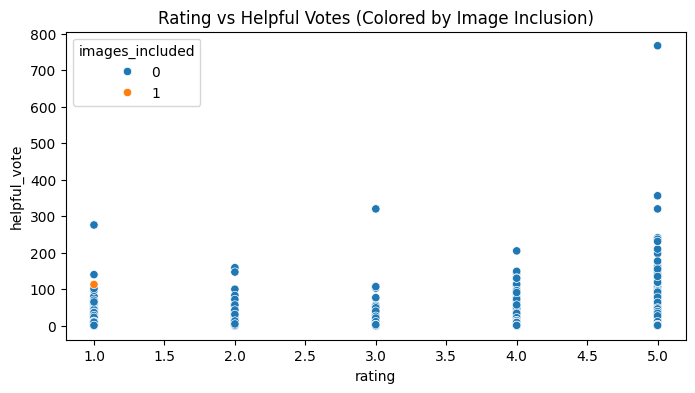

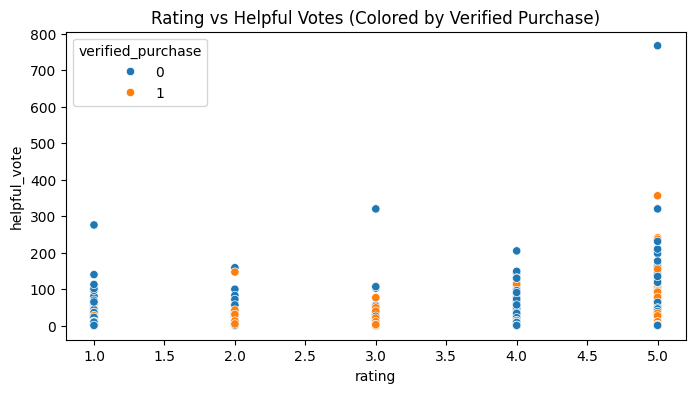

In [ ]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='rating', y='helpful_vote', hue='images_included', data=review_df)
plt.title('Rating vs Helpful Votes (Colored by Image Inclusion)')
plt.show()

plt.figure(figsize=(8, 4))
sns.scatterplot(x='rating', y='helpful_vote', hue='verified_purchase', data=review_df)
plt.title('Rating vs Helpful Votes (Colored by Verified Purchase)')
plt.show()

##***Violin Plot (Helpful Votes vs. Rating):***
*(top 5% helpful vote count excluded)*

<ipython-input-30-63d556af38d2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(filtered_plot_df, x='rating', y='helpful_vote', inner='box', palette='Dark2')


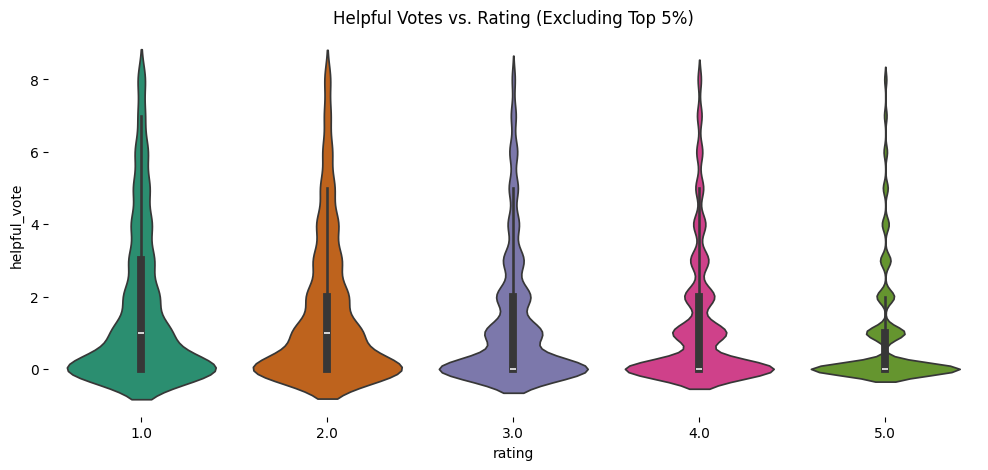

In [ ]:
helpful_vote_threshold = np.percentile(review_df['helpful_vote'], 95)
filtered_plot_df = review_df[review_df['helpful_vote'] <= helpful_vote_threshold]


plt.figure(figsize=(12,5))
plt.title("Helpful Votes vs. Rating (Excluding Top 5%)")
sns.violinplot(filtered_plot_df, x='rating', y='helpful_vote', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

plt.show()

##**Exploratory Data Analysis (NLP):**

##***Imports & Installs:***

In [ ]:
#imports
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


##***Preprocessing (NLP):***


This Natural Language Processing (NLP) script performs exploratory data analysis on review text data. It includes:

- Text Preprocessing: Converts text to lowercase, removes punctuation, tokenizes words, filters out stopwords, and lemmatizes tokens. This processed text is stored in a new column, processed_text.
- Sentiment Word Bank: Defines lists of positive, negative, and neutral words to classify the sentiment of each review.
- Sentiment Classification: For each review, calculates the proportions of positive, negative, and neutral words using the predefined word banks. These proportions are stored in the DataFrame as positive_ratio, negative_ratio, and neutral_ratio columns.
- Feature Engineering: Creates numerical sentiment features for analysis and modeling, enabling insights into the overall sentiment distribution across reviews.

This workflow transforms raw text data into a structured format for further sentiment analysis.

In [ ]:
#@title Define our Lemmatizer and Text Preprocessing Function
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    #1: lowercase
    text = text.lower()

    #2: no punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    #3: tokenize
    tokens = nltk.word_tokenize(text)

    #4: remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    #5: join back our tokens into a single string to return
    return ' '.join(tokens)

In [ ]:
#@title Preprocess the dataset (and sample) - this takes a while
review_df['processed_text'] = review_df['text'].apply(preprocess)

In [ ]:
#@title Copy the Dataframe for NLP Modeling and Analysis Specific Operations
nlp_review_df = review_df.copy()

In [ ]:
#@title Defining our Sentiment-classification Word Banks
positive_words = {
    "excellent", "amazing", "outstanding", "perfect", "durable", "reliable",
    "high-quality", "premium", "superior", "well-made", "easy", "convenient",
    "simple", "intuitive", "user-friendly", "smooth", "efficient", "hassle-free",
    "comfortable", "worthwhile", "affordable", "cost-effective", "reasonable",
    "valuable", "economical", "beautiful", "sleek", "stylish", "attractive",
    "modern", "elegant", "powerful", "fast", "effective", "accurate",
    "consistent", "responsive", "versatile", "helpful", "friendly", "prompt",
    "supportive", "trustworthy", "honest", "love", "happy", "impressive",
    "satisfied", "recommend", "best", "fantastic", "great", "innovative",
    "creative", "unique", "clean", "fresh", "exceptional", "brilliant",
    "remarkable", "top-notch", "first-rate", "superb", "phenomenal", "terrific",
    "marvelous", "splendid", "delightful", "pleasing", "commendable",
    "notable", "extraordinary", "fabulous", "awesome", "spectacular",
    "incredible", "astounding", "magnificent", "impeccable", "flawless",
    "unmatched", "unparalleled", "unbeatable", "unrivaled", "stellar",
    "supreme", "exquisite", "admirable", "praiseworthy", "glorious", "radiant",
    "charming", "enchanting", "captivating", "alluring", "appealing",
    "engaging", "enthralling", "mesmerizing", "breathtaking", "stunning",
    "gorgeous", "dazzling", "memorable", "noteworthy", "distinguished",
    "esteemed", "respected", "valued", "appreciated", "cherished", "treasured",
    "prized", "beloved", "lauded", "acclaimed", "celebrated", "renowned",
    "famed", "illustrious", "eminent", "prestigious", "reputable"
}
negative_words = {
    "bad", "poor", "terrible", "awful", "horrible", "difficult", "disappointing",
    "flimsy", "unreliable", "cheap", "uncomfortable", "broken", "defective",
    "unusable", "worst", "ugly", "annoying", "overpriced", "ineffective",
    "slow", "confusing", "frustrating", "inconsistent", "low-quality", "mediocre",
    "unfriendly", "rude", "unhelpful", "misleading", "faulty", "inaccurate",
    "noisy", "useless", "unsatisfactory", "subpar", "shoddy", "problematic",
    "untrustworthy", "unsafe", "inconvenient", "inefficient", "unresponsive",
    "overhyped", "unpleasant", "disastrous", "ridiculous", "worthless",
    "malfunctioning", "undependable", "irritating", "disheartening"
}
neutral_words = {
    "average", "okay", "decent", "satisfactory", "fair", "moderate",
    "acceptable", "standard", "ordinary", "functional", "workable",
    "basic", "typical", "predictable", "adequate", "common", "expected",
    "generic", "passable", "regular", "middling", "normal", "tolerable",
    "unremarkable", "unspectacular", "plain", "vanilla"
}

In [ ]:
#@title Produce scores for positivity and negativity, as well as relative weights
def classify_words_with_proportions(words, positive_list, negative_list, neutral_list):
    categories = {'positive': 0, 'negative': 0, 'neutral': 0}
    for word in words:
        if word in positive_list:
            categories['positive'] += 1
        elif word in negative_list:
            categories['negative'] += 1
        elif word in neutral_list:
            categories['neutral'] += 1
    total = sum(categories.values())
    if total > 0:
        proportions = {
            'positive': categories['positive'] / total,
            'negative': categories['negative'] / total,
            'neutral': categories['neutral'] / total
        }
    else:
        proportions = {'positive': 0, 'negative': 0, 'neutral': 0}
    return proportions

In [ ]:
#@title Get (3) sentiment ratios for each review
nlp_review_df['word_proportions'] = nlp_review_df['processed_text'].apply(
    lambda x: classify_words_with_proportions(x.split(), positive_words, negative_words, neutral_words)
)
nlp_review_df[['positive_ratio', 'negative_ratio', 'neutral_ratio']] = nlp_review_df['word_proportions'].apply(pd.Series)
nlp_review_df.drop(columns=['word_proportions'], inplace=True)

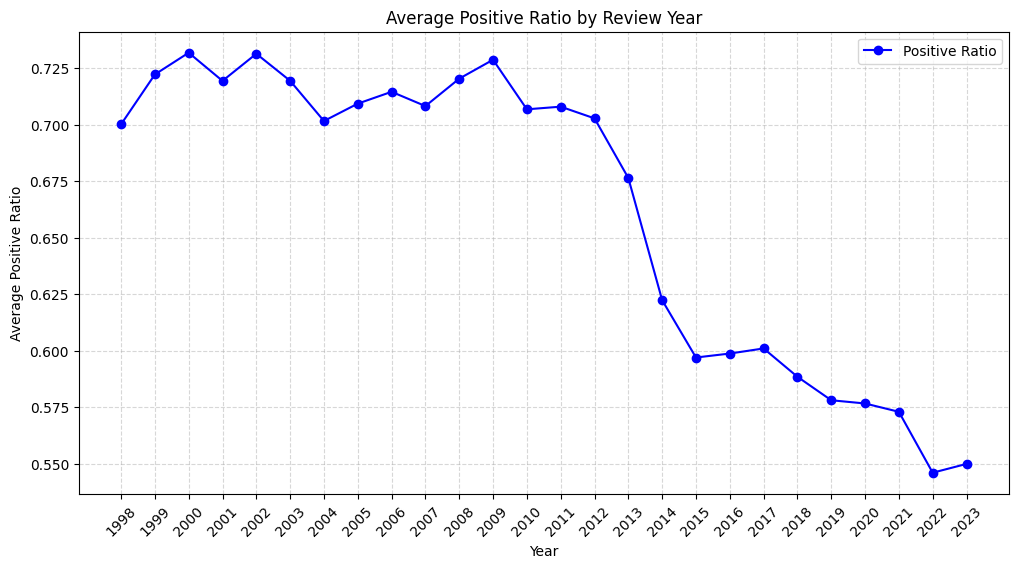

In [ ]:
#@title Average positive Sentiment vs. Year
yearly_positive_ratio = nlp_review_df.groupby('review_year')['positive_ratio'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(yearly_positive_ratio['review_year'], yearly_positive_ratio['positive_ratio'], marker='o', color='blue', label='Positive Ratio')
plt.title('Average Positive Ratio by Review Year')
plt.xlabel('Year')
plt.ylabel('Average Positive Ratio')
plt.xticks(yearly_positive_ratio['review_year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

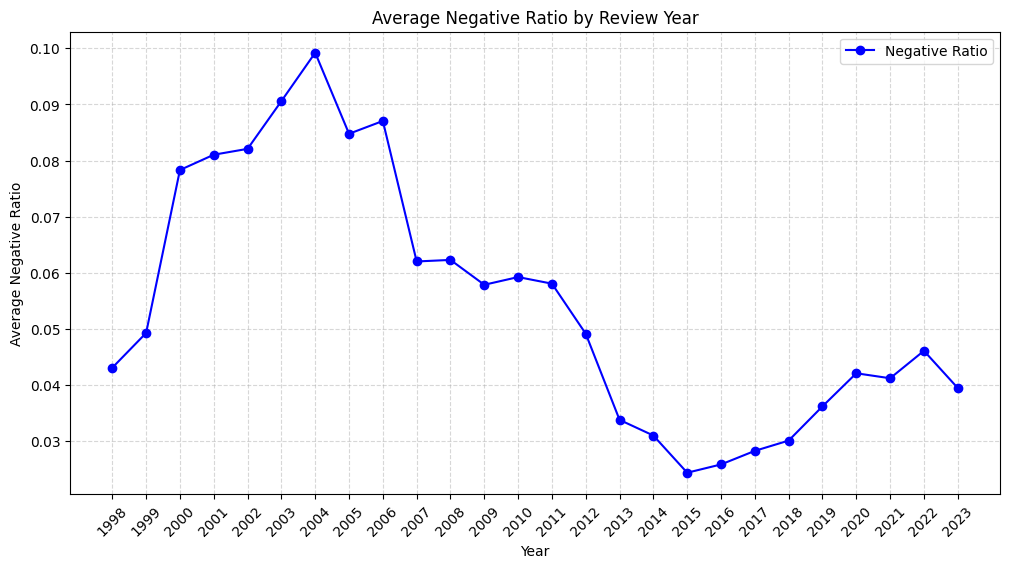

In [ ]:
#@title Average Negative Sentiment vs. Year
nlp_review_df['review_year'] = pd.to_datetime(nlp_review_df['review_time']).dt.year
yearly_negative_ratio = nlp_review_df.groupby('review_year')['negative_ratio'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(yearly_negative_ratio['review_year'], yearly_negative_ratio['negative_ratio'], marker='o', color='blue', label='Negative Ratio')
plt.title('Average Negative Ratio by Review Year')
plt.xlabel('Year')
plt.ylabel('Average Negative Ratio')
plt.xticks(yearly_negative_ratio['review_year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

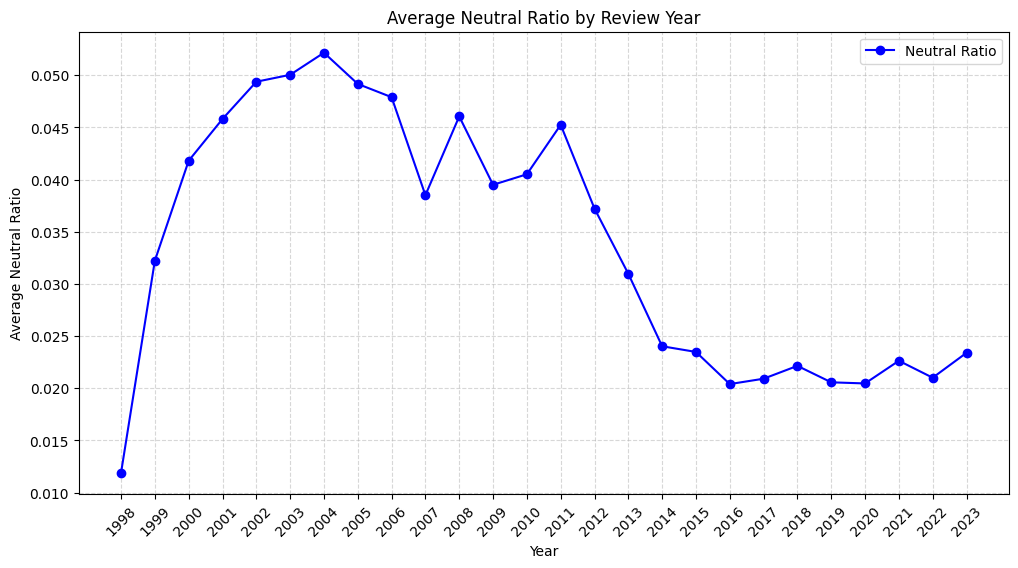

In [ ]:
#@title Average Neutral Sentiment vs. Year
nlp_review_df['review_year'] = pd.to_datetime(nlp_review_df['review_time']).dt.year
yearly_neutral_ratio = nlp_review_df.groupby('review_year')['neutral_ratio'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(yearly_neutral_ratio['review_year'], yearly_neutral_ratio['neutral_ratio'], marker='o', color='blue', label='Neutral Ratio')
plt.title('Average Neutral Ratio by Review Year')
plt.xlabel('Year')
plt.ylabel('Average Neutral Ratio')
plt.xticks(yearly_neutral_ratio['review_year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

##***TF-IDF:***

This code utilizes Term Frequency-Inverse Document Frequency (TF-IDF) to analyze text data and identify unique keywords for different groups in the dataset. It begins by transforming the processed review text into a numerical representation using a TF-IDF vectorizer, limiting the features to the top 1,000 terms for efficiency. The resulting TF-IDF matrix is converted into a DataFrame and enriched with group labels (e.g., categories or classes) for targeted analysis. The script computes the mean TF-IDF score for each term within each group and contrasts it with the overall mean to determine terms that are uniquely significant to specific groups. For each group, the top 20 terms with the highest positive differences are extracted, highlighting their distinctiveness. These group-specific keywords are stored in a dictionary and further organized into a DataFrame for easier interpretation and visualization. This approach helps uncover group-specific text patterns and key differentiators within the data.

In [ ]:
#@title Define the Category to Group By for Our TF-IDF Method & Corresponding Word Cloud
group_by_category = "rating"

In [ ]:
#@title Process With  TF-IDF

vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(nlp_review_df['processed_text'])

feature_names = vectorizer.get_feature_names_out()

#TF-IDF Array -> Pandas DF (so it's easier to work with)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df[group_by_category] = nlp_review_df[group_by_category]

#Calculate mean TF-IDF by (previously defined) grouping category
grouped_tfidf = tfidf_df.groupby(group_by_category).mean()
grouped_tfidf = grouped_tfidf.drop(columns=[group_by_category], errors='ignore')

overall_mean = tfidf_df.drop(columns=[group_by_category]).mean()

In [ ]:
#@title Extract Top 20 Keywords (TF-IDF)
unique_keywords = {}

#Will only consider 20 unique keywords so it looks good for the Word Cloud :)
top_n = 20

for group in grouped_tfidf.index:
    difference = grouped_tfidf.loc[group] - overall_mean
    sorted_terms = difference.sort_values(ascending=False)

    #Select top terms with highest positive difference
    top_terms = sorted_terms[sorted_terms > 0].head(top_n).index.tolist()
    unique_keywords[group] = top_terms

In [ ]:
#@title Visualize the Unique Keywords DF
unique_keywords_df = pd.DataFrame(list(unique_keywords.items()), columns=[group_by_category, 'unique_keywords'])

unique_keywords_df

,rating,unique_keywords
0,1.0,"[money, disappointed, record, bad, case, skip,..."
1,2.0,"[song, sound, like, disappointed, would, much,..."
2,3.0,"[ok, song, good, track, like, better, br, soun..."
3,4.0,"[good, like, song, track, br, album, still, so..."
4,5.0,"[great, love, awesome, excellent, music, best,..."


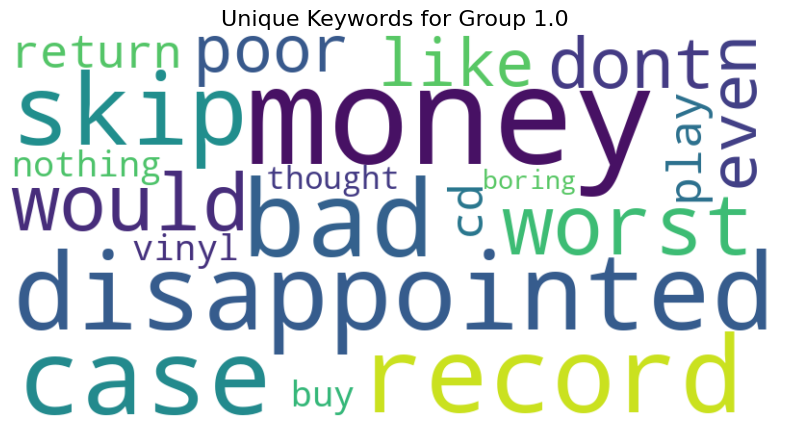

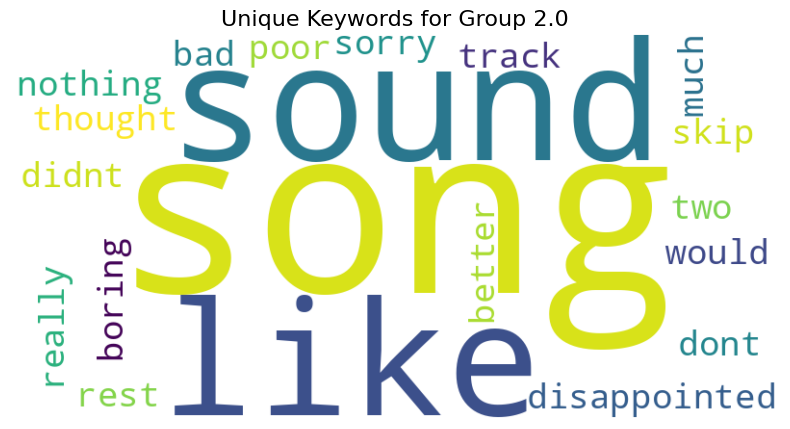

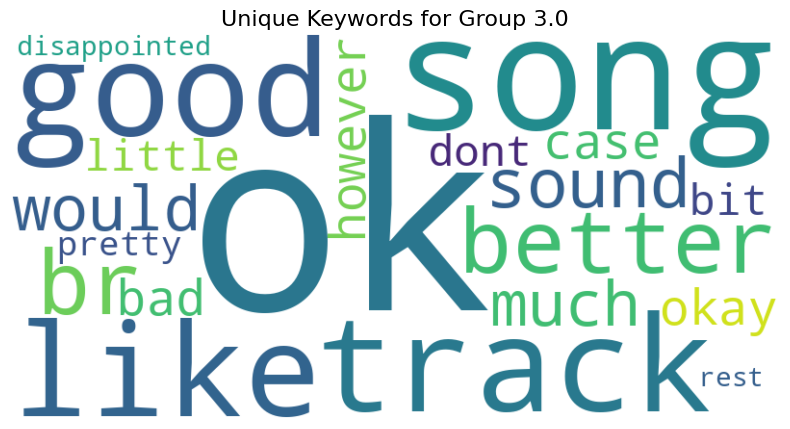

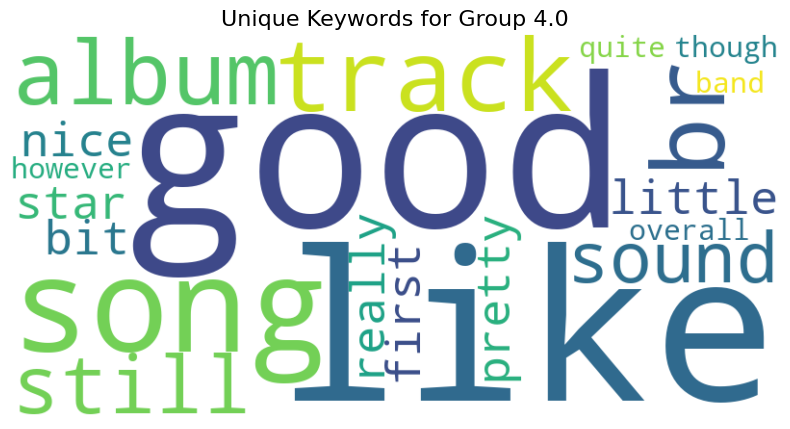

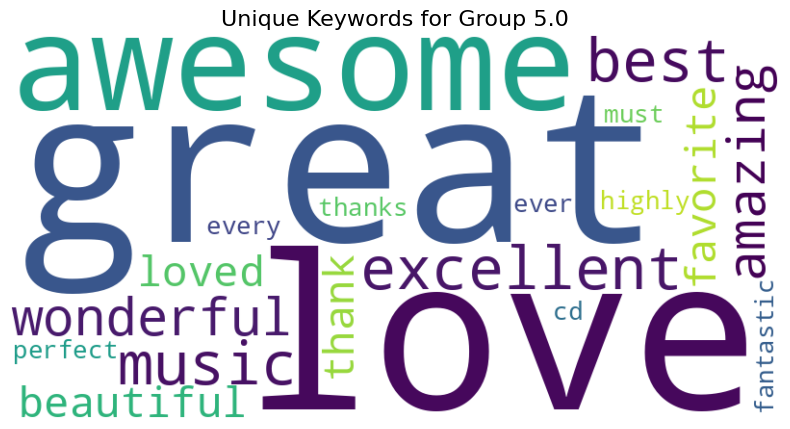

In [ ]:
#@title Visualize with a WordCloud
def generate_wordcloud(keywords, title):
    word_freq = {word: 1 for word in keywords}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

for index, row in unique_keywords_df.iterrows():
    group = row[group_by_category]
    keywords = row['unique_keywords']
    title = f'Unique Keywords for Group {group}'
    generate_wordcloud(keywords, title)

##***VADER Sentiment Analysis***


This code leverages the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to analyze and summarize the sentiment of textual data. First, it uses the SentimentIntensityAnalyzer to compute sentiment scores for each review, generating four key metrics: compound, negative, neutral, and positive sentiment scores. These scores are stored in individual columns within the DataFrame for detailed analysis.

In [ ]:
#@title VADER Sentiment Analysis Calculations - this takes some time
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sid.polarity_scores(text)

#Get sentiment scores from processed text
review_df['sentiment_scores'] = review_df['processed_text'].apply(get_sentiment_scores)

review_df = pd.concat([review_df.drop(['sentiment_scores'], axis=1), review_df['sentiment_scores'].apply(pd.Series)], axis=1)

sentiment_columns = ['compound', 'neg', 'neu', 'pos']

#Calculate average sentiment scores per (pre-defined) group
average_sentiment = review_df.groupby(group_by_category)[sentiment_columns].mean().reset_index()

print("Average VADER Sentiment per Group:")
print(average_sentiment)

Average VADER Sentiment per Group:
   rating  compound       neg       neu       pos
0     1.0  0.145285  0.165492  0.641960  0.190489
1     2.0  0.405835  0.124953  0.633633  0.239393
2     3.0  0.572959  0.084852  0.613575  0.299871
3     4.0  0.695986  0.055537  0.583510  0.359811
4     5.0  0.690787  0.035921  0.507297  0.454466


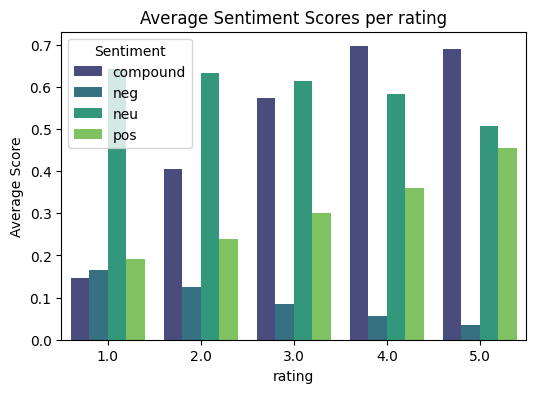

<ipython-input-47-655bc5e50164>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_by_category, y='compound', data=review_df, palette='viridis')


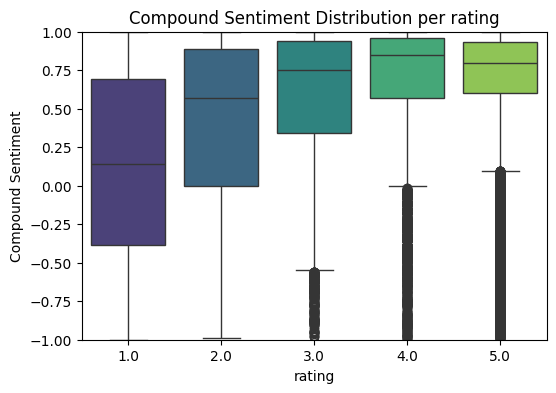

In [ ]:
#@title Sentiment Analysis Visualizations - These Visualizations helped us Generalize Trends in Rating & Sentiment
#Sentiment Proportions per Group
melted_sentiment = average_sentiment.melt(id_vars=group_by_category, value_vars=sentiment_columns, var_name='sentiment', value_name='score')

plt.figure(figsize=(6, 4))
sns.barplot(x=group_by_category, y='score', hue='sentiment', data=melted_sentiment, palette='viridis')
plt.title('Average Sentiment Scores per ' + group_by_category)
plt.xlabel(group_by_category)
plt.ylabel('Average Score')
plt.legend(title='Sentiment')
plt.show()

#Box Plot of Compound Sentiment Distribution per Group
plt.figure(figsize=(6, 4))
sns.boxplot(x=group_by_category, y='compound', data=review_df, palette='viridis')
plt.title('Compound Sentiment Distribution per ' + group_by_category)
plt.xlabel(group_by_category)
plt.ylabel('Compound Sentiment')
plt.ylim(-1, 1)
plt.show()

# **Hypothesis Testing:**

Our general prediction is that customer satisfaction with retail products has declined overtime, which will be tested based on multiple null hypotheses:

1. h0: There is no significant relationship between year posted and negativity of a review.

2. h0: There is no significant relationship between time and median length of reviews.


###Testing Hypothesis 1: Year and Negativity

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
negativity_by_year = review_df.groupby('review_year')['neg']
null_mean_by_year = negativity_by_year.mean()
null_std_by_year = negativity_by_year.std()
length_null = len(review_df)

all_ts = []
for i in range(10_000):
    samples = []
    for _ in range(len(null_mean_by_year)):
        random_year = random.choice(null_mean_by_year.index)
        sample_mean = null_mean_by_year.loc[random_year]
        sample_std = null_std_by_year.loc[random_year]
        samples.append(random.gauss(sample_mean, sample_std))
    all_ts.append(np.mean(samples) - null_mean_by_year.mean())


p_value = np.sum(np.abs(all_ts) >= np.abs(np.mean(samples) - null_mean_by_year.mean())) / len(all_ts)

print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between year and negativity.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between year and negativity.")

P-value: 0.0116
Reject the null hypothesis: There is a significant relationship between year and negativity.


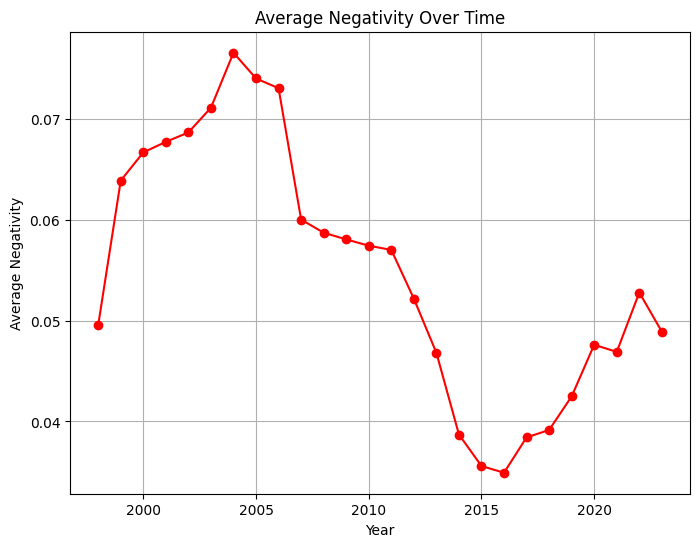

In [ ]:
#@title Visualize Mean Negativity of a Review Over Time
plt.figure(figsize=(8, 6))
plt.plot(negativity_by_year.mean().index, negativity_by_year.mean().values, marker='o', color='red')
plt.title('Average Negativity Over Time')
plt.xlabel('Year')
plt.ylabel('Average Negativity')
plt.grid()
plt.show()

###Testing Hypothesis 2: Time and Median Length of Reviews

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
length_by_year = review_df.groupby('review_year')['review_length'].median()
overall_median_length = review_df['review_length'].median()

all_ts = []
for _ in range(10000):
    samples = []
    for _ in range(len(length_by_year)):
        sample_median = random.choice(length_by_year.values)
        samples.append(sample_median)
    all_ts.append(np.median(samples) - overall_median_length)
observed_stat = np.median(length_by_year) - overall_median_length
p_value = np.sum(np.abs(all_ts) >= np.abs(observed_stat)) / 10000

print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between time and median length of reviews.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between time and median length of reviews.")


P-value: 0.5253
Fail to reject the null hypothesis: There is no significant relationship between time and median length of reviews.


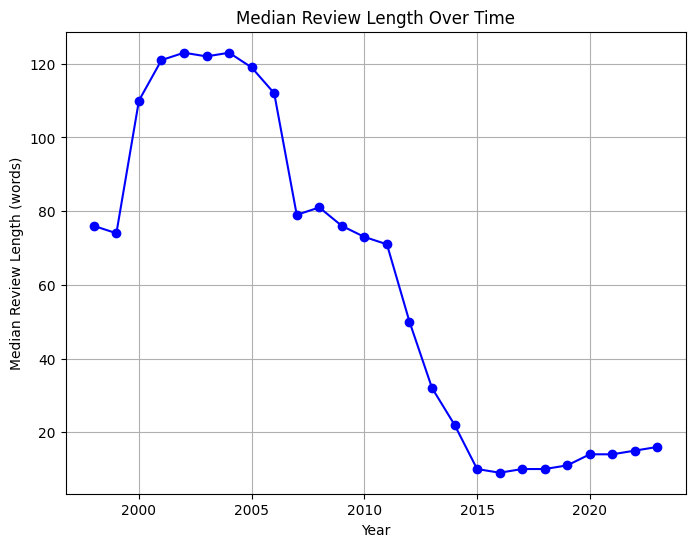

In [ ]:
#@title Visualize Mediant Review Length Over Time
plt.figure(figsize=(8, 6))
plt.plot(length_by_year.index, length_by_year.values, marker='o', color='blue')
plt.title('Median Review Length Over Time')
plt.xlabel('Year')
plt.ylabel('Median Review Length (words)')
plt.grid()
plt.show()

In conslusion, hypothesis testing has revealed that time passing can indeed have a significant relationship to reviews. Specifically, it was revealed that years passing does have a significant impact on negativity. However, while we had hypothesized that negativity would rise with time, it fluctuated and actually lowered a bit. On the other hand, there is no significant relationship between time and average length of reviews.

#***Predictive Modeling:***

#Model Type 1: (Random Forest) Predicting single review value.

We utilized a Random Forest Classifier to predict review ratings based on VADER sentiment analysis scores, focusing on two distinct tasks: classifying reviews as positive or negative and predicting exact numeric ratings. The sentiment scores (compound, neg, neu, pos) serve as input features, while the targets are either categorical (positive vs. negative) or numeric (rating). The data is split into training, validation, and testing sets to ensure robust model evaluation. Hyperparameter tuning is conducted using GridSearchCV to optimize key parameters like the number of estimators and tree depth, improving model performance. For the positive vs. negative classification task, the model evaluates its accuracy, classification metrics, and confusion matrix, while for strict numeric rating predictions, it measures accuracy and the average error in predictions. By leveraging sentiment analysis scores, this workflow demonstrates how Random Forest models can effectively predict and analyze customer sentiment and ratings.

In [ ]:
#@title Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##***VADER Sentiment Analysis Predictive Modeling:***

In [ ]:
#@title Prepare the Data for Modeling
X = review_df[['compound', 'neg', 'neu', 'pos']]
y_pos_vs_neg = review_df['rating']
y_numeric = review_df['rating']

In [ ]:
#@title Convert Ratings to Categories - Positive vs. Negative (rating)
def categorize_rating(rating):
    if rating >= 4:
        return "Positive"
    else:
        return "Negative"

y_pos_vs_neg = review_df['rating'].apply(categorize_rating)

In [ ]:
#@title Function for Random Forest Classifier Hyperparameter Tuning
def random_forest_hyperparameter_tuning(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [50, 75],
        'max_depth': [10, 15],
    }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), param_grid, cv=2, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return best_params, accuracy

In [ ]:
#@title Function for Train/Test/Split
def custom_train_test_split(X, y, val_size=0.05, test_size=0.2, random_state=RANDOM_SEED):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
#@title Train Test Split - Positive vs. Negative (rating)
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split(X, y_pos_vs_neg)

In [ ]:
#@title Apply Oversampling
smote = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
#@title Random Forest Classifier Model - Balanced Class Weight - Positive vs. Negative (rating)

best_params, accuracy = random_forest_hyperparameter_tuning(X_res, y_res, X_val, y_val)

model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', **best_params)

model.fit(X_res, y_res)

y_pred = model.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Random Forest Model Accuracy: 0.7257
              precision    recall  f1-score   support

    Negative       0.26      0.63      0.37      2542
    Positive       0.93      0.74      0.82     17458

    accuracy                           0.73     20000
   macro avg       0.60      0.68      0.60     20000
weighted avg       0.85      0.73      0.77     20000

Confusion Matrix:
[[ 1599   943]
 [ 4543 12915]]


In [ ]:
#@title Train Test Split - Strict Numeric (rating)
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split(X, y_numeric)

In [ ]:
#@title Apply Oversampling
smote = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
#@title Random Forest Classifier Model - Balanced Class Weight - Strict Numeric (rating)

best_params, accuracy = random_forest_hyperparameter_tuning(X_res, y_res, X_val, y_val)

model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', **best_params)

model.fit(X_res, y_res)

y_pred = model.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
average_off_by = abs(y_test - y_pred).mean()
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Strict Numeric Model Accuracy: {accuracy}")
print(f"Average Rating Prediction Off By: {average_off_by}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_mat)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Strict Numeric Model Accuracy: 0.469
Average Rating Prediction Off By: 1.06455
              precision    recall  f1-score   support

         1.0       0.12      0.42      0.19       773
         2.0       0.06      0.20      0.10       576
         3.0       0.10      0.19      0.13      1193
         4.0       0.18      0.24      0.21      2747
         5.0       0.85      0.55      0.66     14711

    accuracy                           0.47     20000
   macro avg       0.26      0.32      0.26     20000
weighted avg       0.66      0.47      0.54     20000

Confusion Matrix:
[[ 326  148  144   73   82]
 [ 143  117  103  114   99]
 [ 231  183  231  280  268]
 [ 366  298  415  669  999]
 [1578 1076 1408 2612 8037]]


##***Multi-Feature Predictive Modeling (Sentiment+):***

This code extends predictive modeling by incorporating multiple features to predict review ratings using a Random Forest Classifier. The input features include sentiment analysis scores (compound, neg, neu, pos), review-specific features (e.g., helpful votes, verified purchases, and images included), and item-specific features (e.g., rating numbers and price). The goal is to predict either the sentiment category (positive vs. negative) or the strict numeric rating.
The data preparation involves a combination of sentiment, review-specific, and item-specific attributes, creating a comprehensive feature set for the model. The script employs hyperparameter tuning with GridSearchCV to find the optimal configuration for the Random Forest Classifier, ensuring improved performance.

In [ ]:
#@title Prepare the Data for Modeling
X = review_df[[
    'compound', 'neg', 'neu', 'pos', #Type 1: Sentiment Analysis Features
    'helpful_vote', 'verified_purchase', 'images_included', #Type 2: Review-specific Features
    'rating_number', 'price' #Type 3: Item-specific Features
    ]]

In [ ]:
#@title Train Test Split - Positive vs. Negative (rating)
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split(X, y_pos_vs_neg)

In [ ]:
#@title Apply Oversampling
smote = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
#@title Random Forest Classifier Model - Balanced Class Weight - Positive vs. Negative (rating)

best_params, accuracy = random_forest_hyperparameter_tuning(X_res, y_res, X_val, y_val)

model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', **best_params)

model.fit(X_res, y_res)

y_pred = model.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Positive vs. Negative Model Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Positive vs. Negative Model Accuracy: 0.78005
              precision    recall  f1-score   support

    Negative       0.29      0.52      0.38      2542
    Positive       0.92      0.82      0.87     17458

    accuracy                           0.78     20000
   macro avg       0.61      0.67      0.62     20000
weighted avg       0.84      0.78      0.80     20000



In [ ]:
#@title Train Test Split - Strict Numeric (rating)
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_test_split(X, y_numeric)

In [ ]:
#@title Apply Oversampling
smote = SMOTE(random_state=RANDOM_SEED)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [ ]:
#@title Random Forest Classifier Model - Balanced Class Weight - Strict Numeric (rating)

#Initialize
best_params, accuracy = random_forest_hyperparameter_tuning(X_res, y_res, X_val, y_val)

model = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', **best_params)

model.fit(X_res, y_res)

#Make Predictions
y_pred = model.predict(X_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
average_off_by = abs(y_test - y_pred).mean()
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Strict Numeric Model Accuracy: {accuracy}")
print(f"Average Rating Prediction Off By: {average_off_by}")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_mat)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Strict Numeric Model Accuracy: 0.583
Average Rating Prediction Off By: 0.7649
              precision    recall  f1-score   support

         1.0       0.23      0.45      0.30       773
         2.0       0.07      0.18      0.11       576
         3.0       0.10      0.12      0.11      1193
         4.0       0.20      0.19      0.20      2747
         5.0       0.82      0.72      0.76     14711

    accuracy                           0.58     20000
   macro avg       0.28      0.33      0.30     20000
weighted avg       0.64      0.58      0.61     20000

Confusion Matrix:
[[  346   125    56    39   207]
 [  151   105    69    81   170]
 [  159   153   148   230   503]
 [  201   226   278   534  1508]
 [  669   805   875  1835 10527]]


#Model Type 2: (XBGRegressor) Predicting the compound sentiment of the text of a review given other review and product information.

This code uses an XGBRegressor model to predict the compound sentiment score of reviews based on review-specific and product-specific features. The data is preprocessed with one-hot encoding for categorical features and scaling for numeric features. After splitting the data into training and testing sets, hyperparameter tuning optimizes the model's performance. The final model predicts sentiment scores, evaluated using metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²), highlighting the relationship between product attributes, reviews, and overall sentiment polarity

In [ ]:
#@title XGBRegressor Model to predict compound sentiment (good for continuous value prediction).
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


y = review_df['compound']

categorical_features = ['main_category', 'store']
numeric_features = [
    'rating_number', 'price', 'review_length', 'average_rating',
    'helpful_vote', 'images_included', 'rating'
]

X = review_df[categorical_features + numeric_features].copy()

#Handle missing values if present
X = X.fillna({'main_category': 'unknown', 'store': 'unknown'})
X[numeric_features] = X[numeric_features].fillna(X[numeric_features].median())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#Categorical pipeline: One-hot encoding
cat_pipeline = OneHotEncoder(handle_unknown='ignore')

#Numeric pipeline: Scaling
num_pipeline = StandardScaler()

#Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numeric_features)
])

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

In [ ]:
#@title Hyperparameter Tuning for XGBRegressor Model

# # # # # # # # # Grader Note: the crossvalidation process takes a while. Uncomment the following param grid
# # # # # # # # # for representative results. Otherwise, use the simplified parameter grid (uncommented)
# param_grid = {
#     'model__n_estimators': [100, 300, 500],
#     'model__learning_rate': [0.1, 0.05, 0.02, 0.01],
#     'model__max_depth': [5, 7, 9]
# }

param_grid = {
    'model__n_estimators': [100],
    'model__learning_rate': [0.1],
    'model__max_depth': [5]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best score: 0.1079948080670227


In [ ]:
#@title Fit Model
model = XGBRegressor(n_estimators=grid_search.best_params_['model__n_estimators'],
                     learning_rate=grid_search.best_params_['model__learning_rate'],
                     max_depth=grid_search.best_params_['model__max_depth'],
                     random_state=RANDOM_SEED)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)

In [ ]:
#@title Evaluate (we are most interested in MAE: for being a standard metric for XGB, and R^2: for explaining variance)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = pipeline.score(X_test, y_test)

print("Model Performance on Test Set:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

Model Performance on Test Set:
MSE: 0.1059
MAE: 0.2192
R^2: 0.2561


#Model Type 3 (Log Regression w/ Embeddings) Predicting sentiment value given review text

This code employs a Logistic Regression model with embeddings from DistilBERT to predict the dominant sentiment (positive, negative, or neutral) of review text. A smaller sample of 1,500 reviews is used for efficiency, with the sentiment category determined by the maximum score among positive, negative, and neutral sentiment values.

The review text is tokenized using a pre-trained DistilBERT tokenizer, and embeddings are extracted from the [CLS] token of the model's final hidden state. These embeddings serve as input features for the Logistic Regression model, which is trained to classify sentiment categories. After generating embeddings for both training and test sets, the model predicts the sentiment of the test data, achieving an accuracy score to evaluate its performance. This approach combines state-of-the-art language embeddings with a simple yet effective classifier to analyze sentiment from textual data.

In [ ]:
smaller_sample = review_df.sample(n=1000, random_state=RANDOM_SEED)

#max out of pos,neg,neu
X = smaller_sample['processed_text'].copy()
y = smaller_sample[['pos', 'neg', 'neu']].idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = RANDOM_SEED)

In [ ]:
#@title Get Embeddings (*CODE IS ADOPTED FROM HW4*)
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

model.eval()

def get_embeddings(texts, tokenizer, model, max_len=128):
    embeddings = []

    for text in texts:
        input_tokens = tokenizer(
            text,
            add_special_tokens = True,
            max_length = max_len,
            padding = 'max_length',
            truncation = True,
            return_tensors = 'pt'
        )

        with torch.no_grad():
            outputs = model(**input_tokens)
            cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().numpy()
            embeddings.append(cls_embedding)

    return embeddings

#get train and test embeddings
train_embeddings = get_embeddings(X_train, tokenizer, model)
test_embeddings = get_embeddings(X_test, tokenizer, model)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
#Fit a Logistic Regression model
#Get predictions
lrm = LogisticRegression(max_iter=5000)
lrm.fit(train_embeddings, y_train)
predictions = lrm.predict(test_embeddings)

acc_score = accuracy_score(y_test, predictions)

print(acc_score)

0.87


# **Results and Discussion:**

Our findings are split into observations about the previous data and predictions about sentiment.

Observations:

1. The Natural Language Processing section revealed that positive sentiment was lowered over time, while neutral and negative fluctuated, with the three evening in recent years.

2. As mentioned above, the hypothesis tests showed that time passing does have a significant effect on sentiment, with the significant relationship mainly being shown between year passing and negativity.

3. Our baseline RFC models showed that we could pretty accurately pinpoint a review's numerical rating with increasingly complex bases of engineered features.

4. We were able to explain ~26% of the variance in compound sentiment with our numeric features (i.e. price, rating number, etc).

5. We found that for predicting ratings and positive vs negative sentiment, using Multi-Feature Predictive Modeling is more accurate than using single values. Our second and third model types yielded much more significant results than our RFC models considered in model type one.

Implications:

In conclusion, our results imply that, over time, people's sentiment towards products and their use of language to express that sentiment does change. The observation that reviews tend to even out and use more neutral language implies that later generations are either less expressive with language or have a wider variety of opinions on different products. Furthermore, key words to describe satisfaction do vary with time. Our correlation heatmap and multi-feature predictive modeling revealed that multiple features of reviews correlate to one another and general sentiment, implying that the nature of reviews differ depending on general satisfaction with a product and that there are patterns to human speech depending on emotion and general satisfaction.

Potential Improvements:

Ideally, we would also want to analyze how industry plays a role in these conclusions. Specifically, we would want to know if the conclusions we drew about the CD-Vinyl industry hold across other industries. It would also be interesting to see how purchasing patterns and reviewing vary across industries. For example, are people generally more satisfied with technology products than beauty?